## Methodology

This project replicates and tests the robustness of the findings from Blau, B. M., Griffith, T. G., & Whitby, R. J. (2021), **"Inflation and Bitcoin: A descriptive time-series analysis."** The study investigates the relationship between Bitcoin returns and inflation by employing Vector Autoregression (VAR) models.

### Data Selection and Preprocessing
The analysis uses **daily data** on Bitcoin returns and U.S. inflation expectations (T5YIFR). The time frame mirrors the original study to ensure comparability. Data was collected from the Federal Reserve Bank of St. Louis (https://fred.stlouisfed.org/series/T5YIFR?t&utm_source=perplexity) and the Yahoo Finance API.
- An Augmented Dickey-Fuller (ADF) test was performed to check for stationarity.  
- Bitcoin returns are calculated as the log-differences of daily closing prices.  
- Inflation is measured using daily inflation expectations (T5YIFR).

### Model Specification
A Vector Autoregression (VAR) model is applied to capture the dynamic relationship between Bitcoin returns and inflation.  
- The optimal lag length was determined using information criteria (AIC, BIC, HQIC).  
- Impulse Response Functions (IRFs) and cumulative IRFs are used to examine the time series effects of the variables over time.  
- Granger causality tests were conducted to assess the direction of causality between the variables.  
- Forecast Error Variance Decomposition (FEVD) was performed to evaluate the proportion of the forecast variance in each variable that is attributable to its own shocks versus shocks from the other variable.

### Results Interpretation
Impulse Response Functions (IRFs) and Forecast Error Variance Decomposition (FEVD) are used to interpret the dynamic interactions between Bitcoin returns and inflation.  
- The IRFs illustrate how Bitcoin returns respond to shocks in inflation and vice versa.  
- The FEVD provides insights into the relative contribution of each shock in explaining the forecast variance over different time horizons.

### Limitations
While this replication confirms some of the key findings of the original study, the results are sensitive to the time period, variable selection, and model assumptions. Additional robustness checks and alternative time periods are discussed in the extended analysis.


## Importing Packages

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import VAR

## Data preprocessing

First, we download data on daily Closing Price of Bitcoin in USD from 31 Dec. 2014 to 01 Jan. 2025 from Yahoo!


In [ ]:
ticker = "BTC-USD"
btc_data = yf.download(ticker, start="2014-12-31", end="2025-01-01")
btc_data.columns = [' '.join(col).strip() for col in btc_data.columns]
btc_data.reset_index(inplace=True)
btc_filtered = btc_data[['Date', 'Close BTC-USD']].copy()
btc_filtered['Date'] = pd.to_datetime(btc_filtered['Date'])

[*********************100%***********************]  1 of 1 completed


Second, we download data on daily inflation expectation (T5YIFR) from St. Louis Federal Reserve bank from from 31 Dec. 2014 to Jan. 2025: https://fred.stlouisfed.org/series/T5YIFR?t&utm_source=perplexity.

As authors analyze time period from 01 Jan. 2019 to 31 Dec. 2020, we filter the data accordingly.

In [ ]:
inf_exp = pd.read_csv(os.path.join(DATA_PATH, 'T5YIFR.csv'))
inf_exp = inf_exp.rename(columns={'observation_date': 'Date'})

inf_exp_filtered = inf_exp[(inf_exp['Date'] >= '2019-01-01') & (inf_exp['Date'] <= '2020-12-31')].copy()
summary = inf_exp_filtered.describe()
print(summary)

           T5YIFR
count  501.000000
mean     1.770559
std      0.198653
min      0.860000
25%      1.690000
50%      1.800000
75%      1.920000
max      2.100000


We merge two time series to one data set using inner join, as T5YIFR is calculated only for working days and some days are missing. Overall, we have 501 observation in selected time period.

In [ ]:
btc_filtered['Date'] = pd.to_datetime(btc_filtered['Date'])
inf_exp_filtered['Date'] = pd.to_datetime(inf_exp_filtered['Date'])

data = pd.merge(inf_exp_filtered, btc_filtered, on='Date', how='inner')

To check that data we are going to use is similar to the data set the authors utilized, we compare descriptional statistics of the two sets, and make a graph of two time series. After seeing they are identical, we proceed with the analysis of the data.

In [ ]:
data = data.replace('.', np.nan)
data = data.dropna()
data = data.sort_values(by='Date')

data['T5YIFR'] = data['T5YIFR'].astype('float')
data['Close BTC-USD'] = data['Close BTC-USD'].astype('float')
dates = data["Date"]
data.reset_index()
data.index = pd.DatetimeIndex(dates)
data=data[["T5YIFR", "Close BTC-USD"]].copy()

print(data.head())
print(data.describe())

            T5YIFR  Close BTC-USD
Date                             
2019-01-02    1.91    3943.409424
2019-01-03    1.87    3836.741211
2019-01-04    1.94    3857.717529
2019-01-07    1.95    4025.248291
2019-01-08    1.98    4030.847900
           T5YIFR  Close BTC-USD
count  501.000000     501.000000
mean     1.770559    9265.593004
std      0.198653    4032.444211
min      0.860000    3399.471680
25%      1.690000    7238.966797
50%      1.800000    9181.017578
75%      1.920000   10583.134766
max      2.100000   29001.720703


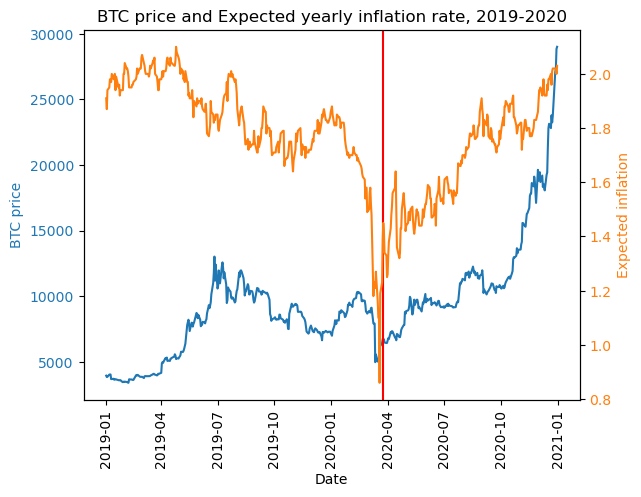

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(data.index, data['Close BTC-USD'], color = 'C0')
ax1.set_xlabel('Date')
ax1.tick_params(axis ='x', rotation=90, zorder=120)
ax1.set_ylabel('BTC price', color = 'C0')
ax1.tick_params(axis ='y', labelcolor = 'C0')
plt.axvline(x="2020-03-24", color = "red")
ax2=ax1.twinx() #Create new graph that shares the previous x-axis
ax2.plot(data.index, data['T5YIFR'], color = 'C1')
ax2.set_ylabel('Expected inflation', color = 'C1')
ax2.tick_params(axis ='y', labelcolor = 'C1')

ax1.set_title('BTC price and Expected yearly inflation rate, 2019-2020')
fig.show()

## Time series analysis

First of all, we check the stationarity of both time series using Augmented Dickey-Fuller test. Basing on the graph, we expect them to be non-stationary.

In [ ]:
stationarity = data['Close BTC-USD']
result = ts.adfuller(stationarity)
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = data['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

data.index = pd.DatetimeIndex(data.index).to_period('D')

For BTC:
ADF Statistic: 2.315469
p-value: 0.998965
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
For Inflation:
ADF Statistic: -1.604979
p-value: 0.481092
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


As ADF Statistic was higher than critical values for both time series, we could not reject the Hypotheses that time series were non-stationary. We proceed with analyzing the first differences of the time series.

In [ ]:
diffdata = data.copy()
diffdata[['Close BTC-USD', 'T5YIFR']] = data[['Close BTC-USD', 'T5YIFR']] .pct_change()
diffdata = diffdata.dropna()

stationarity = diffdata['Close BTC-USD']
result = ts.adfuller(stationarity)
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = diffdata['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

For BTC:
ADF Statistic: -15.276638
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
For Inflation:
ADF Statistic: -8.891896
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


Basing on the fact that ADF Statistic is lower that 1% level of significance critical values for both time series, we conclude that they are I(1), i.e. stationary in the first differences.

As both time series were not I(0), we check if there exists a stationary linear combination of original time series, i.e. if Bitcoin price and Inflation expectation are cointegrated.

In [ ]:
result=ts.coint(data['T5YIFR'], data['Close BTC-USD'])
print('No-cointegration test p-value: %f' % result[1])

No-cointegration test p-value: 0.708938


As p-value of cointegration test is larger than 0.1, we cannot reject the hypothesis that there is no cointegration between the time series.
So, there is **no significant co-integration** between T5YIFR (Inflation Expectation) and BTC-USD (Bitcoin price).

## VAR model

As both time series are I(1), and there is no cointegration between them, we decided to use VAR model. To derive the optimal lag length, we compare not just one AIC criterion like in the paper, but all three AIC, BIC and HQIC. Finally, we present our findings in a graph.

In [ ]:
def select_lag_length(diffdata, max_lags=15):
    lag_results = pd.DataFrame(index=range(1, max_lags+1), columns=['AIC', 'BIC', 'HQIC'])

    for lag in range(1, max_lags+1):
        model = VAR(diffdata)
        results = model.fit(lag)

        lag_results.loc[lag, 'AIC'] = results.aic
        lag_results.loc[lag, 'BIC'] = results.bic
        lag_results.loc[lag, 'HQIC'] = results.hqic

    return lag_results

lag_criteria = select_lag_length(diffdata, max_lags=15)
print(lag_criteria)

          AIC        BIC       HQIC
1  -13.219267 -13.168614 -13.199389
2  -13.228579 -13.144029 -13.195396
3  -13.234598 -13.116046 -13.188066
4  -13.311652 -13.158994 -13.251728
5  -13.349614 -13.162744 -13.276255
6  -13.374648 -13.153462  -13.28781
7  -13.373088 -13.117479 -13.272727
8  -13.369623 -13.079485 -13.255695
9  -13.363335  -13.03856 -13.235795
10 -13.368779 -13.009258 -13.227582
11 -13.358261 -12.963887 -13.203363
12 -13.342374 -12.913038 -13.173729
13 -13.328389 -12.863982 -13.145953
14  -13.34086 -12.841271 -13.144586
15  -13.32378   -12.7889 -13.113622


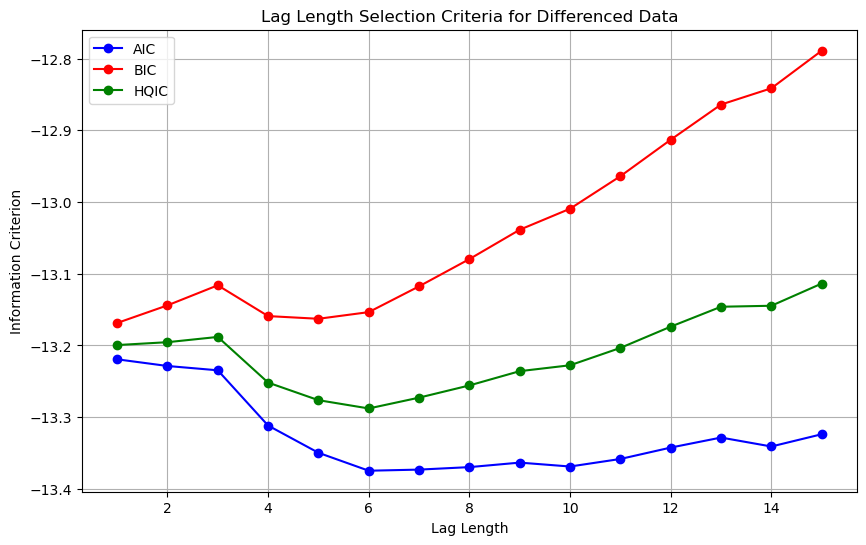

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(lag_criteria.index, lag_criteria['AIC'], label='AIC', color='blue', marker='o')
plt.plot(lag_criteria.index, lag_criteria['BIC'], label='BIC', color='red', marker='o')
plt.plot(lag_criteria.index, lag_criteria['HQIC'], label='HQIC', color='green', marker='o')

plt.title('Lag Length Selection Criteria for Differenced Data')
plt.xlabel('Lag Length')
plt.ylabel('Information Criterion')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### Optimal Lag Length Selection

- **AIC**: Favors more complex models (more lags), which may lead to **overfitting**.
- **BIC**: Penalizes more for additional parameters, often suggesting simpler models to avoid **overfitting** but possibly leading to **underfitting**.
- **HQIC**: A balance between AIC and BIC, aiming to avoid both **overfitting** and **underfitting**.

Authors highlighted numbers of lags of 1, 3 and 5. We however, see point in choosing 6 lags or even 10 lags. First, from interpretational point of view, we think that BTC price and inflation expectation would rather have mid-term relationship rather than short-term, as we think that the actual influence of variables is indirect and requires some time to take effect on each other. Second, criteria's values are relatively lower for these numbers of lags.

We are taking 6 lags for our main model, but we will discuss other lags further.


In [ ]:
optimal_lag = 6

model = VAR(diffdata)
results = model.fit(optimal_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jan, 2025
Time:                     16:25:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.1535
Nobs:                     494.000    HQIC:                  -13.2878
Log likelihood:           1927.63    FPE:                1.55409e-06
AIC:                     -13.3746    Det(Omega_mle):     1.47541e-06
--------------------------------------------------------------------
Results for equation T5YIFR
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.000363         0.001265           -0.287           0.774
L1.T5YIFR               -0.119223         0.044792           -2.662           0.008
L1.Close BTC-USD         0.080814         0.027

In [ ]:
print(results.test_causality('Close BTC-USD', 'T5YIFR', kind='wald'))
print(results.test_causality('T5YIFR', 'Close BTC-USD', kind='wald'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: T5YIFR does not Granger-cause Close BTC-USD: fail to reject at 5% significance level. Test statistic: 4.730, critical value: 12.592>, p-value: 0.579>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Close BTC-USD does not Granger-cause T5YIFR: reject at 5% significance level. Test statistic: 64.561, critical value: 12.592>, p-value: 0.000>


Here we present the summary of the model and also Granger-Causality-tests for both directions. We note that we get the same result, as the authors here: we cannot reject the hypothesis that Expected inflation does not Granger-Cause Bitcoin price, but we reject the other hypothesis on 1% level of significance, basing on p-values.

We get that Bitcoin Price Granger-Causes Expected inflation rate and not vice versa, thus it can serve as an inflation hedge.

#### Impulse response analysis

We construct the graphs for impulse response functions and cumulative impulse reponse functions for 20 periods.

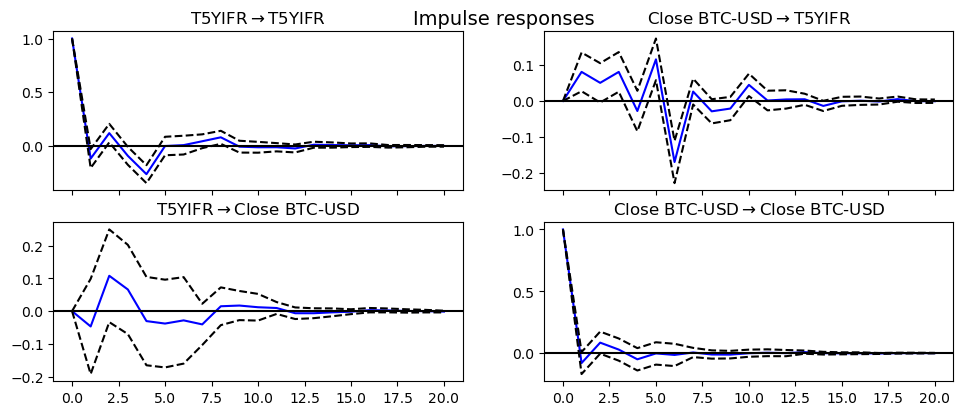

In [ ]:
irf = results.irf(20)
irf.plot(figsize=(10, 4))
plt.show()

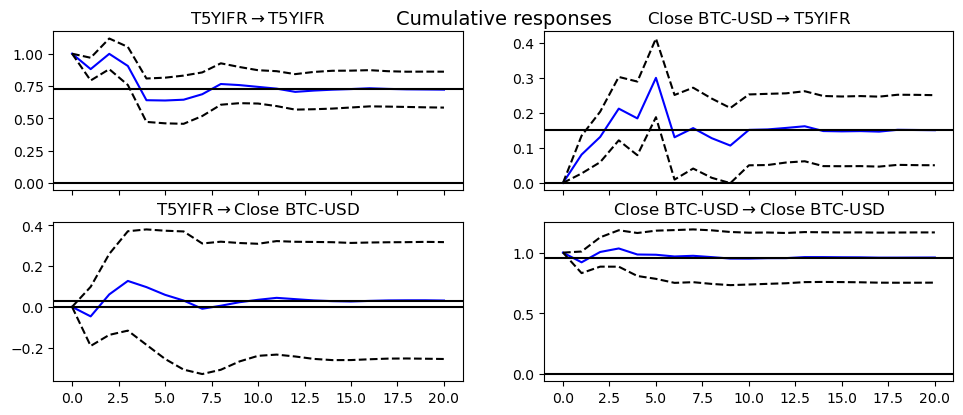

In [ ]:
irf.plot_cum_effects(orth=False, figsize=(10, 4))
plt.show()

As we can see from CRF graph, we have the same result as the authors in the paper: BTC has a mid-long-term effect on expected inflation that stabilizes around 0.15 and can be considered significant as confidence intervals do not intersect 0.

As expected, expected inflation does not seem to have a significant effect on Bitcoin price in any term.

Then, we proceed with error variance decomposition.

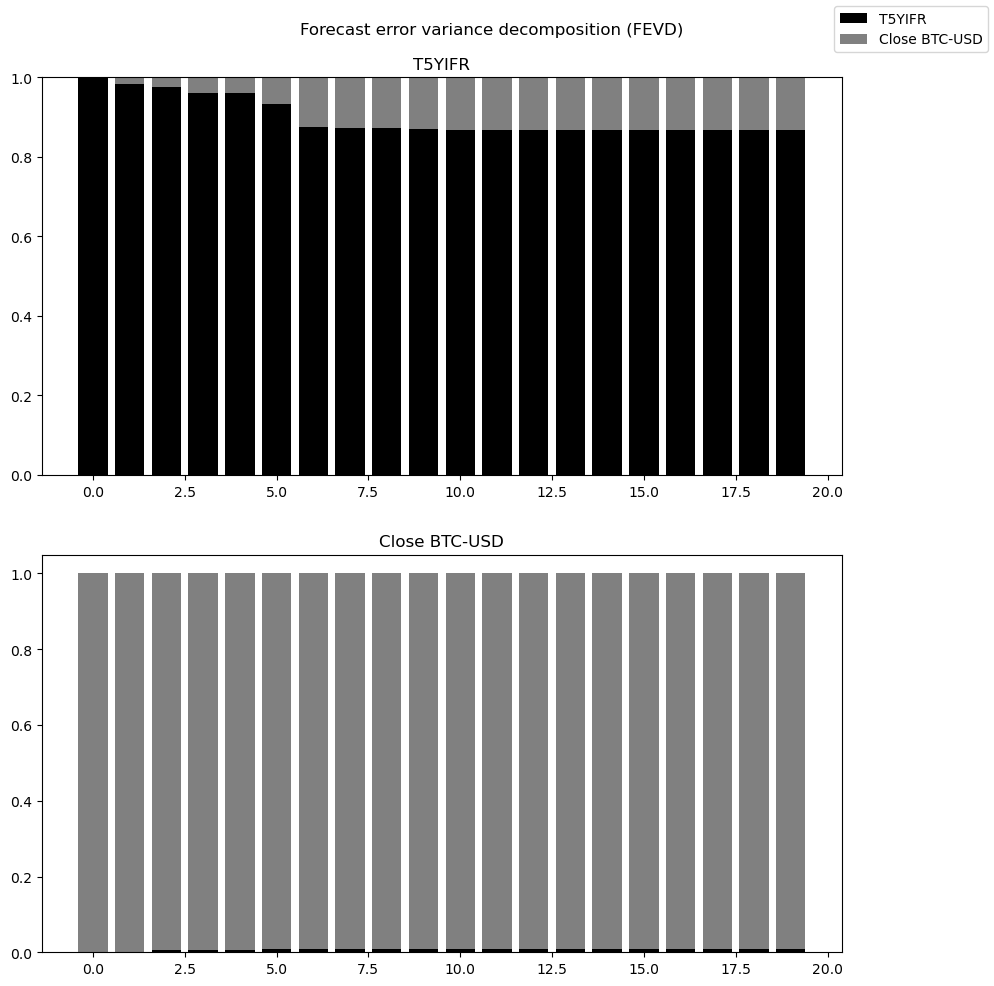

In [ ]:
results.fevd(20).plot()
plt.show()

As we can see, most of error variance is created by variable itself for both variables. As is also seen from CIRF graphs, variables mainly depend on themselves rather than on the other variable.

## Discussing authors' findings

We now replicate the results from the paper and discuss the results the authors get.

First, we construct CIRFs for VAR(1), Var(3) and VAR(5):

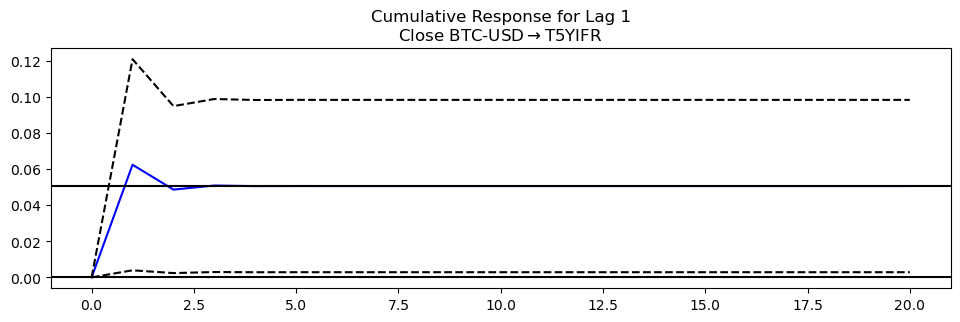

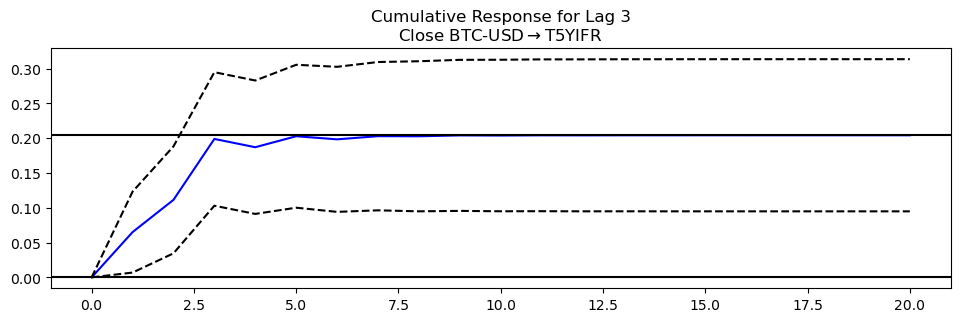

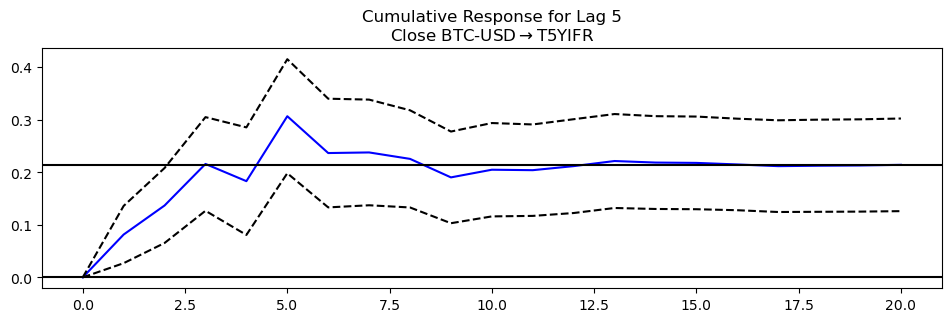

In [ ]:
optimal_lag = [1, 3, 5]
for lag in optimal_lag:
    model = VAR(diffdata)
    results = model.fit(lag)
    irf = results.irf(20)
    irf.plot_cum_effects(response="T5YIFR",
                         impulse="Close BTC-USD",
                         orth=False,
                         figsize=(10, 3))
    plt.suptitle(f'Cumulative Response for Lag {lag}', fontsize=12)
    plt.subplots_adjust(top=0.85)
    plt.show()

We get the same CIRFs, as in the paper and see that the effect of Bitcoin price on T5YIFR is consistent for any number of chosen lags.

#### Robustness check

Then, we do the experiment authors conducted. The idea is to split the data  into two sets: pre-pandemic one (01.01.2019-24.03.2020) and pandemic (25.03.2020-31.12.2020) and compare the results. Two time periods are very different in terms of economic environment, and similar results could confirm robustness of the findings.

In [ ]:
pre_inf = inf_exp[(inf_exp['Date'] >= '2019-01-01') & (inf_exp['Date'] <= '2020-03-24')].copy()
post_inf = inf_exp[(inf_exp['Date'] >= '2020-03-25') & (inf_exp['Date'] <= '2020-12-31')].copy()
pre_inf['Date'] = pd.to_datetime(pre_inf['Date'])
post_inf['Date'] = pd.to_datetime(post_inf['Date'])

pre_data = pd.merge(pre_inf, btc_filtered, on='Date', how='inner')
post_data = pd.merge(post_inf, btc_filtered, on='Date', how='inner')

pre_data = pre_data.replace('.', np.nan)
pre_data = pre_data.dropna()
pre_data = pre_data.sort_values(by='Date')

post_data = post_data.replace('.', np.nan)
post_data = post_data.dropna()
post_data = post_data.sort_values(by='Date')

pre_data['T5YIFR'] = pre_data['T5YIFR'].astype('float')
pre_data['Close BTC-USD'] = pre_data['Close BTC-USD'].astype('float')
dates = pre_data["Date"]
pre_data.reset_index()
pre_data.index = pd.DatetimeIndex(dates)
pre_data=pre_data[["T5YIFR", "Close BTC-USD"]].copy()

post_data['T5YIFR'] = post_data['T5YIFR'].astype('float')
post_data['Close BTC-USD'] = post_data['Close BTC-USD'].astype('float')
dates = post_data["Date"]
post_data.reset_index()
post_data.index = pd.DatetimeIndex(dates)
post_data=post_data[["T5YIFR", "Close BTC-USD"]].copy()

stationarity = pre_data['Close BTC-USD']
result = ts.adfuller(stationarity)
print('Pre-Pandemic Data')
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = pre_data['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = post_data['Close BTC-USD']
result = ts.adfuller(stationarity)
print('Pandemic Data')
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = post_data['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Pre-Pandemic Data
For BTC:
ADF Statistic: -1.814386
p-value: 0.373343
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
For Inflation:
ADF Statistic: 0.189160
p-value: 0.971647
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
Pandemic Data
For BTC:
ADF Statistic: 2.703873
p-value: 0.999087
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
For Inflation:
ADF Statistic: -1.039827
p-value: 0.738463
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


Once again we get that both time series in both sets of data are non-stationary.

In [ ]:
pre_d = pre_data.copy()
pre_d[['Close BTC-USD', 'T5YIFR']] = pre_d[['Close BTC-USD', 'T5YIFR']] .pct_change()
pre_d = pre_d.dropna()

stationarity = pre_d['Close BTC-USD']
result = ts.adfuller(stationarity)
print('Pre-Pandemic Data')
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = pre_d['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

post_d = post_data.copy()
post_d[['Close BTC-USD', 'T5YIFR']] = post_d[['Close BTC-USD', 'T5YIFR']] .pct_change()
post_d = post_d.dropna()

stationarity = post_d['Close BTC-USD']
result = ts.adfuller(stationarity)
print('Pandemic Data')
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = post_d['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

pre_d.index = pd.DatetimeIndex(pre_d.index).to_period('D')
post_d.index = pd.DatetimeIndex(post_d.index).to_period('D')

Pre-Pandemic Data
For BTC:
ADF Statistic: -18.481037
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
For Inflation:
ADF Statistic: -6.410202
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
Pandemic Data
For BTC:
ADF Statistic: -16.045341
p-value: 0.000000
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
For Inflation:
ADF Statistic: -8.141840
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


As can be seen from the table, all time series from both data sets are stationary in the first differences.

The authors use number of lags equal to 3 for this experiment. We create a VAR model for each of the datasets:

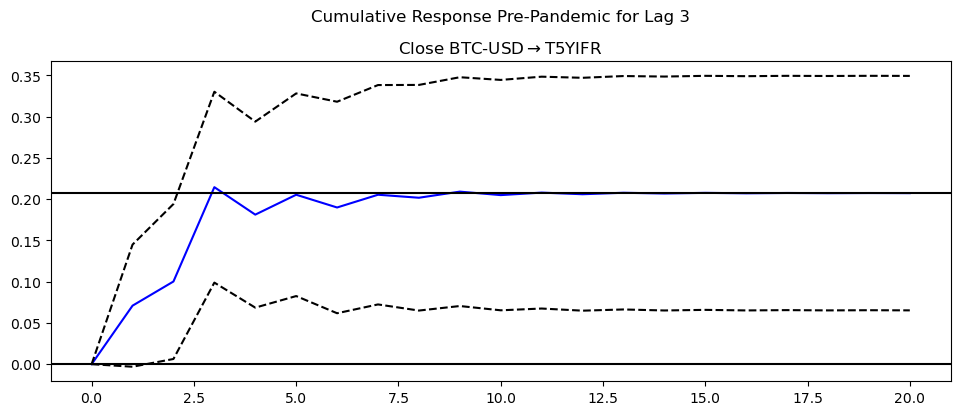

In [ ]:
optimal_lag = 3

model = VAR(pre_d)
results = model.fit(optimal_lag)

irf = results.irf(20)
ir = irf.plot_cum_effects(impulse = "Close BTC-USD", response = "T5YIFR", orth=False, figsize=(10, 4))
plt.suptitle(f'Cumulative Response Pre-Pandemic for Lag {optimal_lag}', fontsize=12)
plt.subplots_adjust(top=0.85)
plt.show()

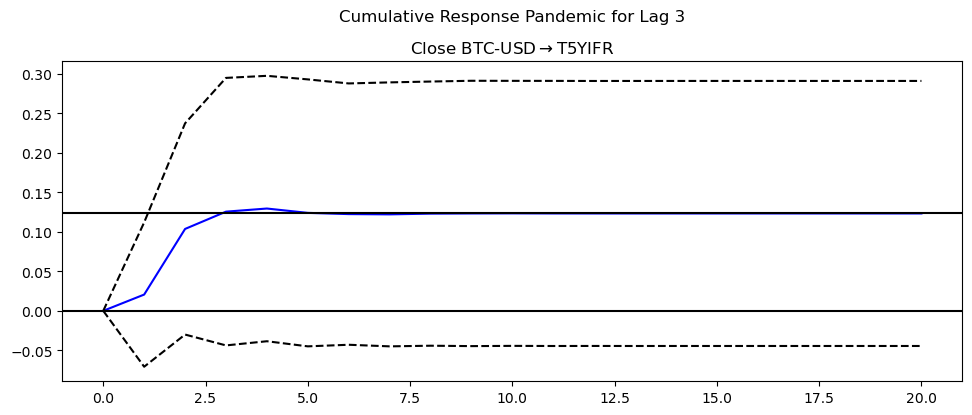

In [ ]:
optimal_lag = 3

model = VAR(post_d)
results = model.fit(optimal_lag)

irf = results.irf(20)
ir=irf.plot_cum_effects(impulse = "Close BTC-USD", response = "T5YIFR", orth=False, figsize=(10, 4))
plt.suptitle(f'Cumulative Response Pandemic for Lag {optimal_lag}', fontsize=12)
plt.subplots_adjust(top=0.85)
plt.show()

Interpreting the graphs, we can say that the results we get are quite similar to the authors'. However, we have to note that both results seem to be insignificant, as for pandemic perod confidence interval intersects 0, which means that variance in this dataset is too high and does not provide enough evidence for robustness of the results.

## Modern data analysis

To furhther develop on robustness, we decided to analyze the most recent available data with similar time period length. We are using exactly the same variables from 01.01.2022 to 31.12.2024.

#### Data preprocessing

In [ ]:
modern_inf = inf_exp[(inf_exp['Date'] >= '2021-12-31') & (inf_exp['Date'] <= '2024-12-31')].copy()
modern_inf['Date'] = pd.to_datetime(modern_inf['Date'])

mdata = pd.merge(modern_inf, btc_filtered, on='Date', how='inner')

mdata = mdata.replace('.', np.nan)
mdata = mdata.dropna()
mdata = mdata.sort_values(by='Date')

mdata['T5YIFR'] = mdata['T5YIFR'].astype('float')
mdata['Close BTC-USD'] = mdata['Close BTC-USD'].astype('float')
dates = mdata["Date"]
mdata.reset_index()
mdata.index = pd.DatetimeIndex(dates)
mdata=mdata[["T5YIFR", "Close BTC-USD"]].copy()

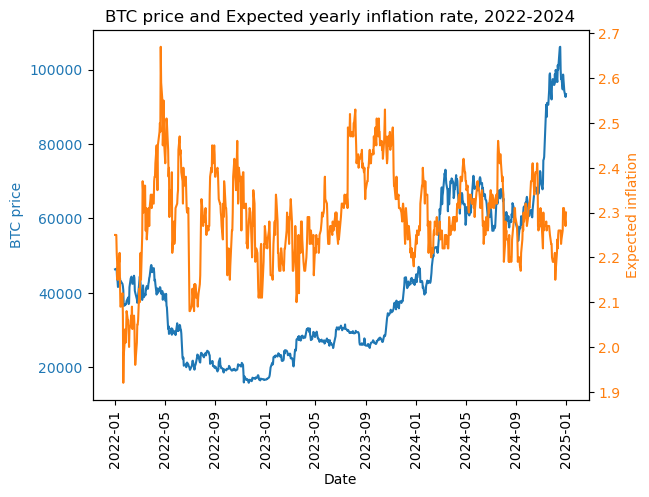

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(mdata.index, mdata['Close BTC-USD'], color = 'C0')
ax1.set_xlabel('Date')
ax1.tick_params(axis ='x', rotation=90, zorder=120)
ax1.set_ylabel('BTC price', color = 'C0')
ax1.tick_params(axis ='y', labelcolor = 'C0')

ax2=ax1.twinx()
ax2.plot(mdata.index, mdata['T5YIFR'], color = 'C1')
ax2.set_ylabel('Expected inflation', color = 'C1')
ax2.tick_params(axis ='y', labelcolor = 'C1')

ax1.set_title('BTC price and Expected yearly inflation rate, 2022-2024')
fig.show()

After creating dataset, we check stationarity of the time series:

In [ ]:
stationarity = mdata['Close BTC-USD']
result = ts.adfuller(stationarity)
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = mdata['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

For BTC:
ADF Statistic: 0.691714
p-value: 0.989671
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
For Inflation:
ADF Statistic: -4.200774
p-value: 0.000657
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


We have that Bitcoin price is not stationary, while Inflation expectation is I(0) on 1% level of significance.

In [ ]:
md = mdata.copy()
md[['Close BTC-USD']] = md[['Close BTC-USD']] .pct_change()
md['T5YIFR'] = md['T5YIFR']/100
md = md.dropna()

stationarity = md['Close BTC-USD']
result = ts.adfuller(stationarity)
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

For BTC:
ADF Statistic: -27.564041
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


After taking the first differences of BTC price, we realise that this time series is I(1), i.e. stationary in the first differences.

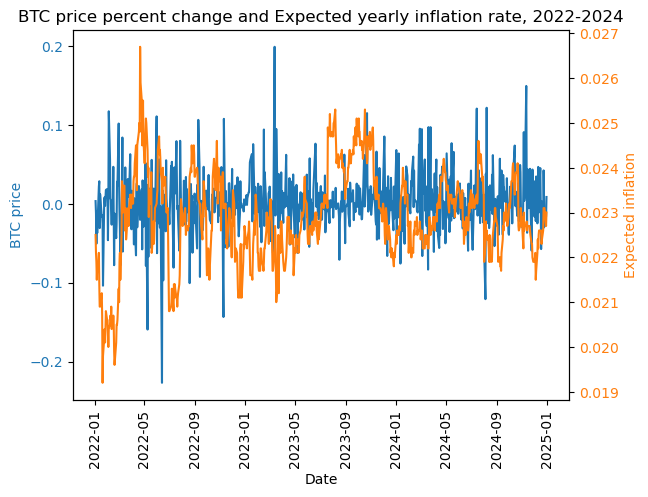

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(md.index, md['Close BTC-USD'], color = 'C0')
ax1.set_xlabel('Date')
ax1.tick_params(axis ='x', rotation=90, zorder=120)
ax1.set_ylabel('BTC price', color = 'C0')
ax1.tick_params(axis ='y', labelcolor = 'C0')

ax2=ax1.twinx()
ax2.plot(md.index, md['T5YIFR'], color = 'C1')
ax2.set_ylabel('Expected inflation', color = 'C1')
ax2.tick_params(axis ='y', labelcolor = 'C1')

ax1.set_title('BTC price percent change and Expected yearly inflation rate, 2022-2024')
fig.show()

md.index = pd.DatetimeIndex(md.index).to_period('D')

#### Optimal lag length

After that, we compute the optimal lag lenght and build a graph foc criterion values:

In [ ]:
def select_lag_length(md, max_lags=15):
    lag_results = pd.DataFrame(index=range(1, max_lags+1), columns=['AIC', 'BIC', 'HQIC'])

    for lag in range(1, max_lags+1):
        model = VAR(md)
        results = model.fit(lag)

        lag_results.loc[lag, 'AIC'] = results.aic
        lag_results.loc[lag, 'BIC'] = results.bic
        lag_results.loc[lag, 'HQIC'] = results.hqic

    return lag_results

lag_criteria = select_lag_length(md, max_lags=15)
print(lag_criteria)

          AIC        BIC       HQIC
1  -22.450065 -22.413027 -22.435792
2  -22.447743 -22.385949 -22.423928
3  -22.448847 -22.362244 -22.415469
4  -22.440807 -22.329343 -22.397844
5  -22.432212 -22.295834 -22.379643
6  -22.422547 -22.261203  -22.36035
7  -22.414908 -22.228546 -22.343062
8  -22.408141 -22.196708 -22.326626
9  -22.406778  -22.17022  -22.31557
10 -22.397989 -22.136253 -22.297067
11 -22.389072 -22.102106 -22.278415
12 -22.379789 -22.067538 -22.259374
13 -22.420387 -22.082797 -22.290192
14 -22.425452 -22.062469 -22.285455
15 -22.425366 -22.036936 -22.275545


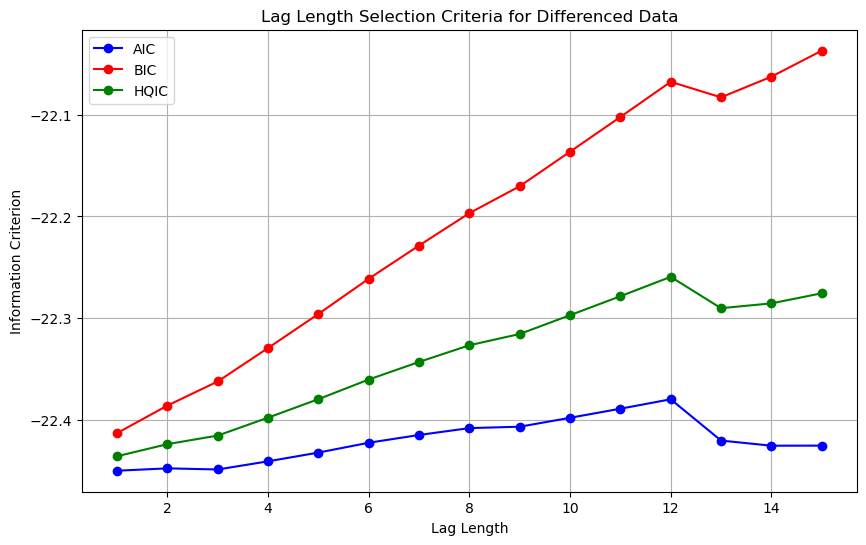

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(lag_criteria.index, lag_criteria['AIC'], label='AIC', color='blue', marker='o')
plt.plot(lag_criteria.index, lag_criteria['BIC'], label='BIC', color='red', marker='o')
plt.plot(lag_criteria.index, lag_criteria['HQIC'], label='HQIC', color='green', marker='o')

plt.title('Lag Length Selection Criteria for Differenced Data')
plt.xlabel('Lag Length')
plt.ylabel('Information Criterion')
plt.legend(loc='best')
plt.grid(True)
plt.show()

We decided to take the optimal lag length of 3, because of the criteria values and because it coincides with authors' approach.

We fit VAR(3) model and test Granger-causality for both time series.

In [ ]:
optimal_lag = 3

model = VAR(md)
results = model.fit(optimal_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jan, 2025
Time:                     16:25:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -22.3622
Nobs:                     746.000    HQIC:                  -22.4155
Log likelihood:           6270.36    FPE:                1.78070e-10
AIC:                     -22.4488    Det(Omega_mle):     1.74774e-10
--------------------------------------------------------------------
Results for equation T5YIFR
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.001282         0.000307            4.174           0.000
L1.T5YIFR                0.886125         0.036606           24.207           0.000
L1.Close BTC-USD         0.000364         0.000

In [ ]:
print(results.test_causality('Close BTC-USD', 'T5YIFR', kind='wald'))
print(results.test_causality('T5YIFR', 'Close BTC-USD', kind='wald'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: T5YIFR does not Granger-cause Close BTC-USD: fail to reject at 5% significance level. Test statistic: 6.930, critical value: 7.815>, p-value: 0.074>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Close BTC-USD does not Granger-cause T5YIFR: fail to reject at 5% significance level. Test statistic: 1.523, critical value: 7.815>, p-value: 0.677>


As can be seen, we get the opposite results here than before: we reject the hypothesis that Expected inflation does not Granger-cause BTC price and we cannot reject the hypothesis about BTC price not Granger-Causing inflation rate.

We construct IRF plots next:

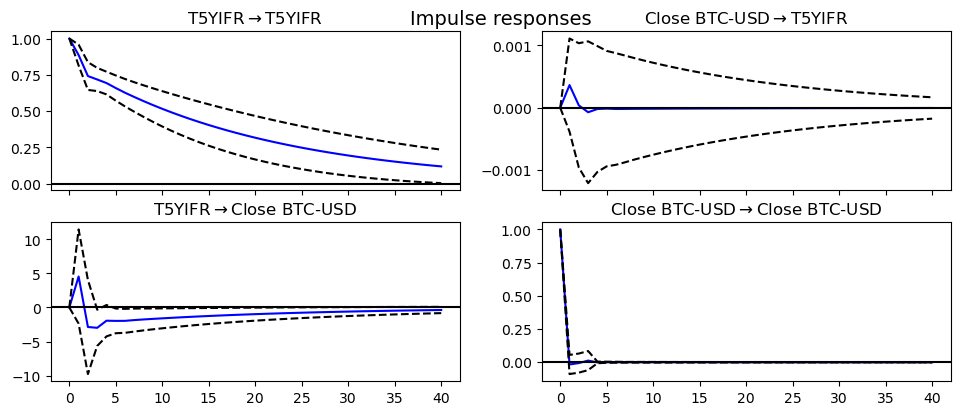

In [ ]:
irf = results.irf(40)
irf.plot(figsize=(10, 4))
plt.show()

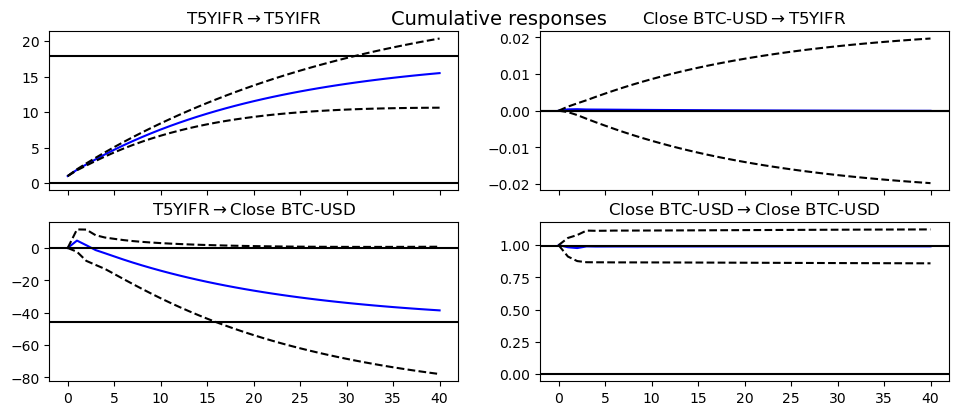

In [ ]:
irf.plot_cum_effects(orth=False, figsize=(10, 4))
plt.show()

As we can see, IRFs graph shows that there may be a long-term effect of expected inflation on BTC price. CIRFs graph for 40 periods, however, shows that if there is the above stated cumulative response, we yet cannot prove it, because the variance is too high, and the confidence interval intersects 0. Probably, if taking a longer period of time, this effect could be significant in a further future, but the time window we chose does not allow to analyze that.

Interestingly, in the modern data we cannot trace any influence of BTC on inflation that we have noted before and the authors were centering their work about. Unfortunately, we cannot thus agree with the authors' claim for robustness of their results, as in the modern data Bitcoin does not act like a hedge against inflation, but possibly is even influenced by it.

Further ways of researching this problem could be seasonal/trend decomposition: the insignificant effect we discuss in the previous paragraph could be the result of a BTC trend component. Moreover, it may be useful to separate a seasonal component from expected inflation time series, as expectations can be vulnerable to seasonal changes in economic situation. Possibly these two suggestions can improve the model.

# 2015-2018
Next, we want to test the authors' results in a larger and earlier time frame. For this reason, we take the data from 2015 to 2018 and try to replicate the findings of hedging inflation with bitcoin.

In [ ]:
old_inf = inf_exp[(inf_exp['Date'] >= '2014-12-31') & (inf_exp['Date'] <= '2018-12-31')].copy()
old_inf['Date'] = pd.to_datetime(old_inf['Date'])

odata = pd.merge(old_inf, btc_filtered, on='Date', how='inner')

odata = odata.replace('.', np.nan)
odata = odata.dropna()
odata = odata.sort_values(by='Date')

odata['T5YIFR'] = odata['T5YIFR'].astype('float')
odata['Close BTC-USD'] = odata['Close BTC-USD'].astype('float')
dates = odata["Date"]
odata.reset_index()
odata.index = pd.DatetimeIndex(dates)
odata=odata[["T5YIFR", "Close BTC-USD"]].copy()

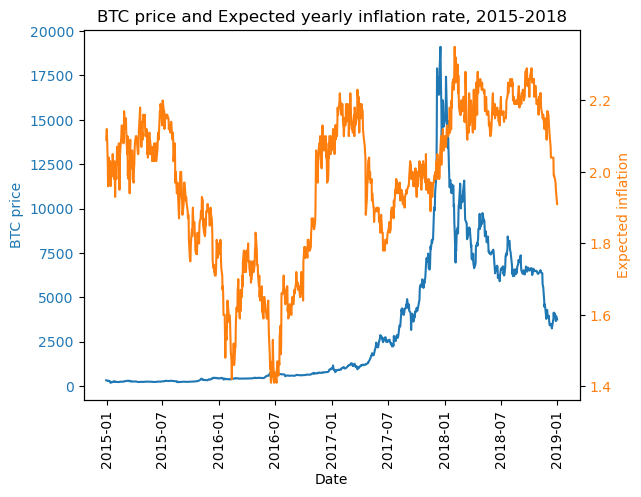

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(odata.index, odata['Close BTC-USD'], color = 'C0')
ax1.set_xlabel('Date')
ax1.tick_params(axis ='x', rotation=90, zorder=120)
ax1.set_ylabel('BTC price', color = 'C0')
ax1.tick_params(axis ='y', labelcolor = 'C0')

ax2=ax1.twinx() #Create new graph that shares the previous x-axis
ax2.plot(odata.index, odata['T5YIFR'], color = 'C1')
ax2.set_ylabel('Expected inflation', color = 'C1')
ax2.tick_params(axis ='y', labelcolor = 'C1')

ax1.set_title('BTC price and Expected yearly inflation rate, 2015-2018')
fig.show()

In [ ]:
stationarity = odata['Close BTC-USD']
result = ts.adfuller(stationarity)
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = odata['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

For BTC:
ADF Statistic: -1.663077
p-value: 0.450230
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
For Inflation:
ADF Statistic: -1.915103
p-value: 0.324990
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


Once again we get that both time series are non-stationary.

In [ ]:
od = odata.copy()
od[['Close BTC-USD', 'T5YIFR']] = od[['Close BTC-USD', 'T5YIFR']] .pct_change()
od = od.dropna()

stationarity = od['Close BTC-USD']
result = ts.adfuller(stationarity)
print('For BTC:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

stationarity = od['T5YIFR']
result = ts.adfuller(stationarity)
print('For Inflation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

For BTC:
ADF Statistic: -7.829800
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
For Inflation:
ADF Statistic: -26.177871
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


After taking the first differences, we reached stationary.

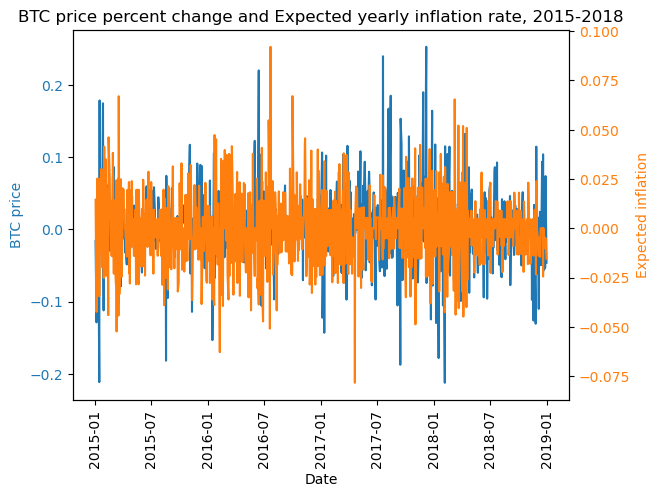

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(od.index, od['Close BTC-USD'], color = 'C0')
ax1.set_xlabel('Date')
ax1.tick_params(axis ='x', rotation=90, zorder=120)
ax1.set_ylabel('BTC price', color = 'C0')
ax1.tick_params(axis ='y', labelcolor = 'C0')

ax2=ax1.twinx() #Create new graph that shares the previous x-axis
ax2.plot(od.index, od['T5YIFR'], color = 'C1')
ax2.set_ylabel('Expected inflation', color = 'C1')
ax2.tick_params(axis ='y', labelcolor = 'C1')

ax1.set_title('BTC price percent change and Expected yearly inflation rate, 2015-2018')
fig.show()

od.index = pd.DatetimeIndex(od.index).to_period('D')

#### Optimal lag length

In [ ]:
def select_lag_length(md, max_lags=15):
    lag_results = pd.DataFrame(index=range(1, max_lags+1), columns=['AIC', 'BIC', 'HQIC'])

    for lag in range(1, max_lags+1):
        model = VAR(od)
        results = model.fit(lag)

        lag_results.loc[lag, 'AIC'] = results.aic
        lag_results.loc[lag, 'BIC'] = results.bic
        lag_results.loc[lag, 'HQIC'] = results.hqic

    return lag_results

lag_criteria = select_lag_length(od, max_lags=15)
print(lag_criteria)

          AIC        BIC       HQIC
1  -14.226135 -14.196665 -14.214934
2  -14.235032 -14.185876 -14.216347
3  -14.236319 -14.167446 -14.210139
4  -14.229777 -14.141155 -14.196088
5  -14.224765 -14.116362 -14.183554
6  -14.217693 -14.089478 -14.168948
7  -14.215574 -14.067516 -14.159283
8  -14.219094 -14.051159 -14.155242
9  -14.236318 -14.048477 -14.164894
10 -14.243498 -14.035717 -14.164488
11 -14.236649 -14.008896  -14.15004
12 -14.239523 -13.991766 -14.145303
13 -14.236311 -13.968517 -14.134466
14 -14.232707 -13.944845 -14.123225
15 -14.226694 -13.918731 -14.109561


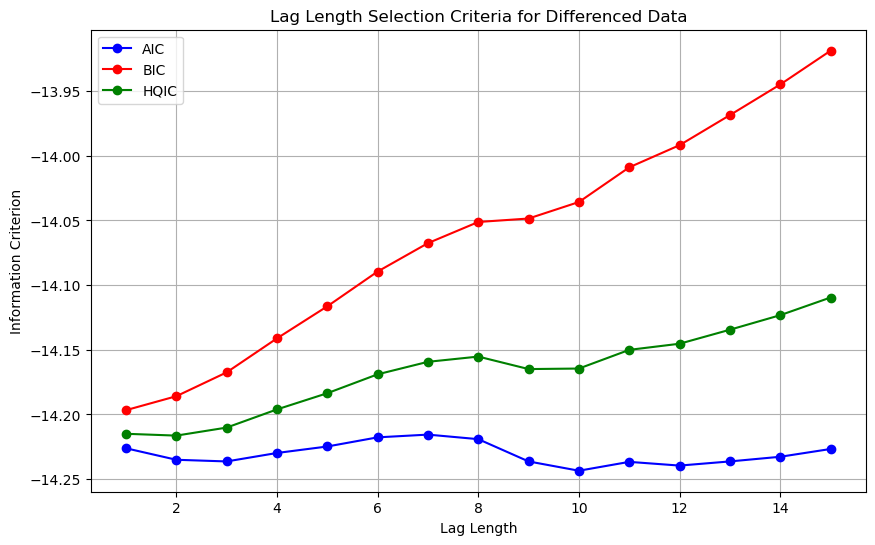

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(lag_criteria.index, lag_criteria['AIC'], label='AIC', color='blue', marker='o')
plt.plot(lag_criteria.index, lag_criteria['BIC'], label='BIC', color='red', marker='o')
plt.plot(lag_criteria.index, lag_criteria['HQIC'], label='HQIC', color='green', marker='o')

plt.title('Lag Length Selection Criteria for Differenced Data')
plt.xlabel('Lag Length')
plt.ylabel('Information Criterion')
plt.legend(loc='best')
plt.grid(True)
plt.show()

We decided to use 10 lags for the VAR model, as this lag length corresponds to the lowest point of the AIC and represents a local minimum for the HQIC. Additionally, as outlined in the initial analysis, we expect a medium-term relationship between the variables, which supports the choice of a longer lag structure.


In [ ]:
optimal_lag = 10

model = VAR(od)
results = model.fit(optimal_lag)

print(results.summary())
print(results.test_causality('Close BTC-USD', 'T5YIFR', kind='wald'))
print(results.test_causality('T5YIFR', 'Close BTC-USD', kind='wald'))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jan, 2025
Time:                     16:33:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.0357
Nobs:                     990.000    HQIC:                  -14.1645
Log likelihood:           4283.03    FPE:                6.51828e-07
AIC:                     -14.2435    Det(Omega_mle):     6.25030e-07
--------------------------------------------------------------------
Results for equation T5YIFR
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.000311         0.000570            0.545           0.586
L1.T5YIFR                -0.193974         0.032167           -6.030           0.000
L1.Close BTC-USD         -0.004689         

The Granger causality test has very high p-values for each causal direction, meaning that neither bitcoin nor inflation expectations seem to have a causal effect on each other.

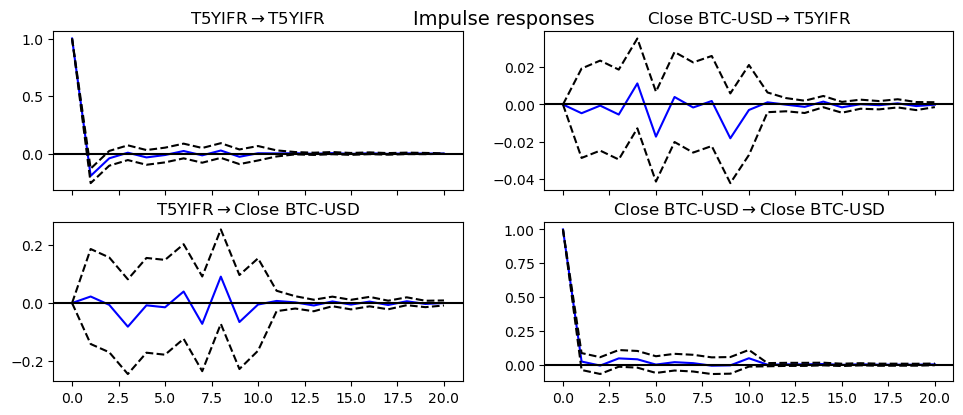

In [ ]:
irf = results.irf(20)
irf.plot(figsize=(10, 4))
plt.show()

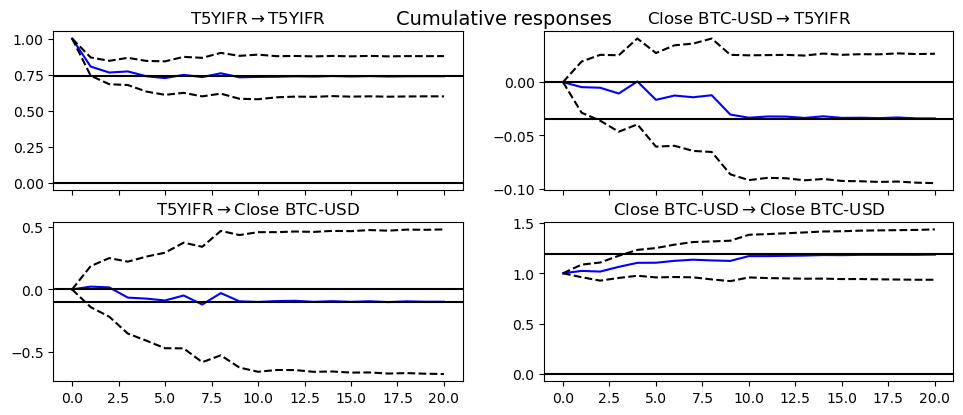

In [ ]:
irf.plot_cum_effects(orth=False, figsize=(10, 4))
plt.show()

In the IRF and in the CIRF we can not see any significant effect.

## 📌 Conclusion

This project replicates and tests the robustness of the findings from Blau, B. M., Griffith, T. G., & Whitby, R. J. (2021), *"Inflation and Bitcoin: A descriptive time-series analysis"*, by examining the dynamic relationship between Bitcoin returns and U.S. inflation expectations (T5YIFR) across **three different time periods**:

### **Time Periods Analyzed**
- **2015–2018**  
- **2019–2020** *(Reproduction of the original study)*  
- **2022–2024**

### **Key Findings Across Time Periods**
- **Time Period 2015–2018**:
  - **Granger Causality**: The Engle-Granger test revealed no relationship between Bitcoin returns and inflation expectations. There was no significant Granger causality in either direction.
  - **IRFs**: The Impulse Response Functions (IRFs) showed that neither inflation nor Bitcoin returns significantly affect each other.

- **Time Period 2019–2020** (Reproduction of the original paper):
  - **Granger Causality**: The analysis found that Bitcoin prices Granger-cause expected inflation, but not the other way around, suggesting that Bitcoin can act as an inflation hedge.
  - **IRFs**: The IRFs show that Bitcoin has a significant mid- to long-term effect on expected inflation, which stabilizes around 0.15.

- **Time Period 2022–2024**:
  - **Granger Causality**: The results in this period were opposite to those found by the authors: Expected inflation rate Granger-causes Bitcoin price, but not vice versa.
  - **IRFs**: We observed a possible long-term effect of expected inflation on Bitcoin price. However, the cumulative impulse response for 40 periods showed high variance, preventing us from confirming this relationship with certainty.

### **Conclusion**
The results consistently suggest that **Bitcoin does not act as a reliable hedge against inflation** across the analyzed time periods. Despite differing the different time periods, the relationship between Bitcoin and inflation expectations remains weak and statistically insignificant.  
These findings imply that Bitcoin may not serve as an effective hedge against inflation.

